In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 3
num_attr_vals = 5
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 125 unqiue cards
Generated 7750 cardpairs
-- 3750 cardpairs with shared concept
-- 4000 cardpairs without shared concept
[(0, 4000), (1, 3000), (2, 750)]
Total number of matches =  108750
Number of shared concepts per match =  [(1, 105000), (2, 3750)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1.0000000000000001e-100, 860000), (9.195402298850577e-06, 108750)]

In [5]:
np.sum(count_table)

108750.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 61
xy_div_xyind_rank= 61


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

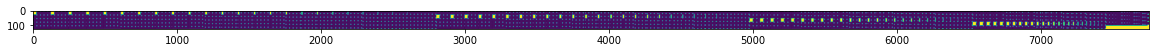

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

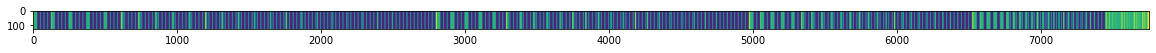

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

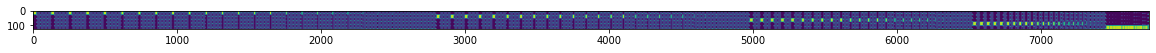

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

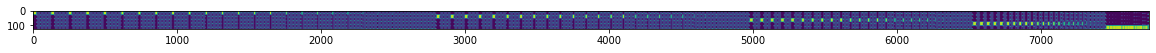

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, 300)

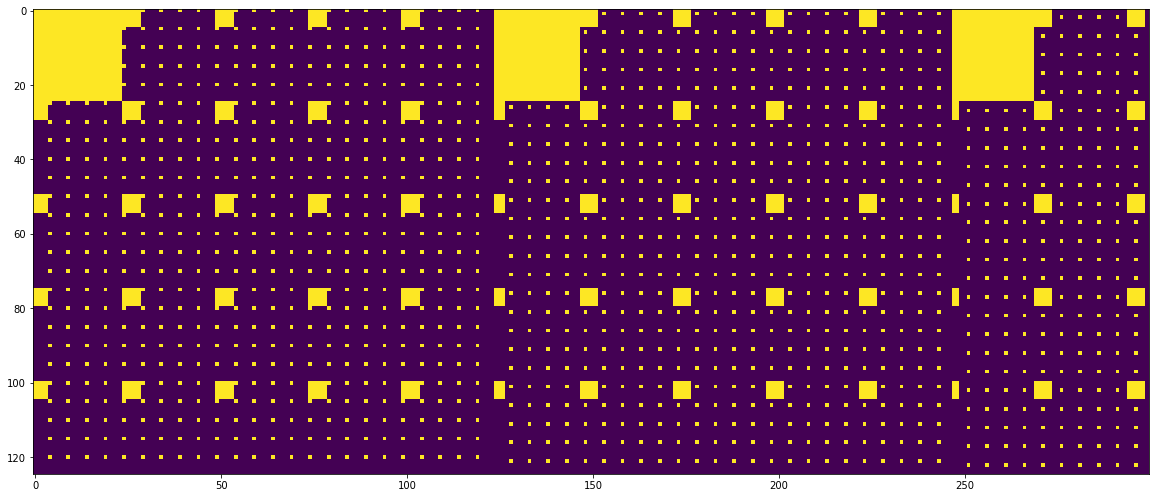

In [13]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

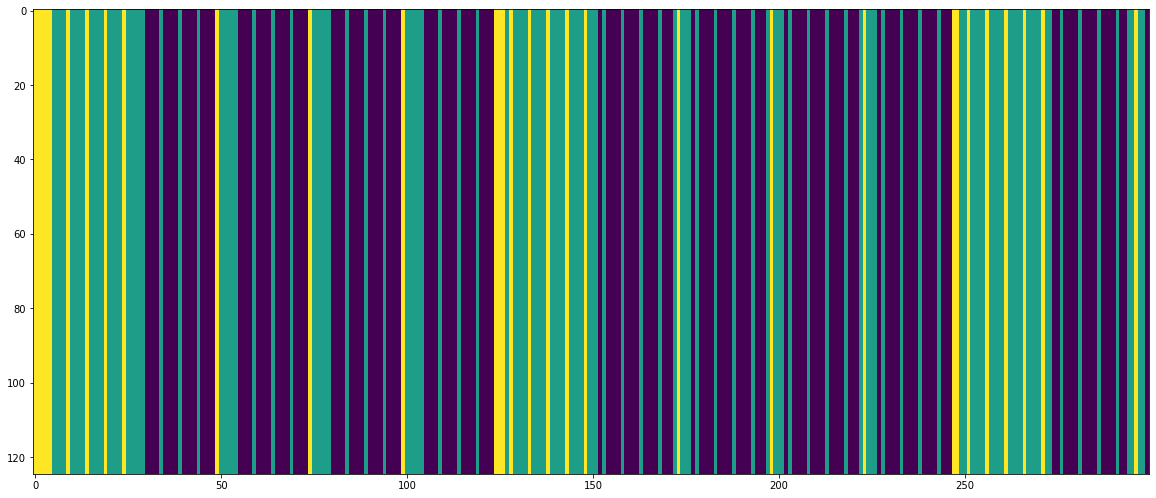

In [14]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

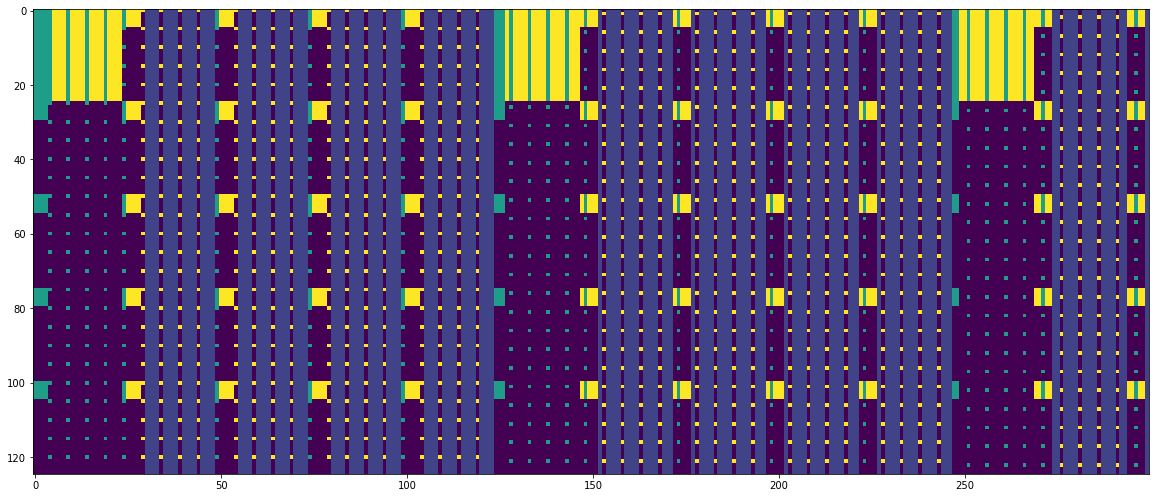

In [15]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

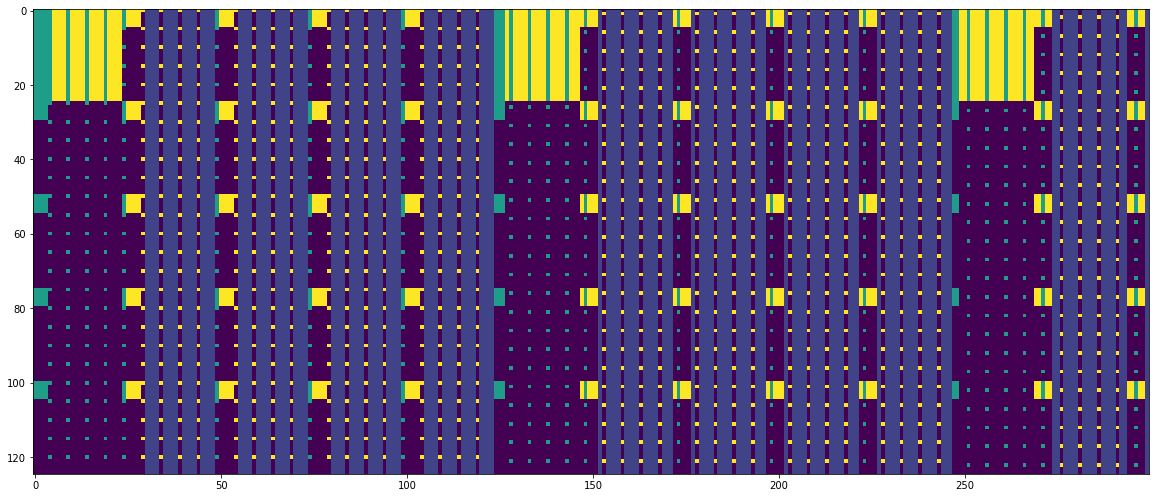

In [16]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [17]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(1.0000000000000018, 296000),
 (1.0000000000000016, 188000),
 (5.437500000000001e-95, 177600),
 (5.4375e-95, 112800),
 (5.000000000000001, 44400),
 (3.020833333333334e-95, 35520),
 (5.0, 28200),
 (3.020833333333333e-95, 24480),
 (2.7777777777777786, 19980),
 (1.0000000000000013, 16000),
 (2.7777777777777777, 12690),
 (5.437499999999999e-95, 9600),
 (4.999999999999999, 2400),
 (2.7777777777777772, 1080)]

## Dataset

In [18]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('red', 'solid', 'circle')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void', 'star'), ('red', 'void', 'hexagon'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'dashed', 'star'), ('red', 'dashed', 'hexagon'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle'), ('red', 'solid', 'star'), ('red', 'solid', 'hexagon'), ('red', 'checkered', 'square'), ('red', 'checkered', 'circle'), ('red', 'checkered', 'triangle'), ('red', 'checkered', 'star'), ('red', 'checkered', 'hexagon'), ('red', 'dotted', 'square'), ('red', 'dotted', 'circle'), ('red', 'dotted', 'triangle'), ('red', 'dotted', 'star'), ('red', 'dotted', 'hexagon')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'dashed', 'star')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('re

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]))

In [19]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('red', 'solid', 'circle')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void', 'star'), ('red', 'void', 'hexagon'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'dashed', 'star'), ('red', 'dashed', 'hexagon'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle'), ('red', 'solid', 'star'), ('red', 'solid', 'hexagon'), ('red', 'checkered', 'square'), ('red', 'checkered', 'circle'), ('red', 'checkered', 'triangle'), ('red', 'checkered', 'star'), ('red', 'checkered', 'hexagon'), ('red', 'dotted', 'square'), ('red', 'dotted', 'circle'), ('red', 'dotted', 'triangle'), ('red', 'dotted', 'star'), ('red', 'dotted', 'hexagon')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'dashed', 'star')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void'

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]))

In [20]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [21]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [22]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [23]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [24]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [25]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [26]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [27]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 128,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 1.0 M 
1  | model.inp_query_layer                        | Sequential         | 992 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 992 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 992 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 16.0 K
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 16.0 K
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 16.0 K
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [ ]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=50000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-28-49cb5c6af813>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 7750112 bytes
wandb: WARNING Serializing object of type ndarray that is 7750112 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 1.0 M 
1  | model.inp_query_layer                        | Sequential         | 992 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 992 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 992 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 16.0 K
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 16.0 K
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 16.0 K
8  | loss_criterion                              

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=4.64e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=4.5e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  2.00it/s, loss=4.58e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=4.56e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=4.56e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=4.6e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=4.63e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=4.61e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s, loss=4.63e+03, v_num=d3vx]
Validating: 0i

Epoch 33:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s, loss=4.32e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=4.27e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=4.28e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  2.00it/s, loss=4.28e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=4.26e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=4.24e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=4.21e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  2.00it/s, loss=4.19e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=4.17e+03, v_num=d3vx]
Valid

Epoch 65:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=3.98e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 66:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=3.97e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 67:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=3.93e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=3.91e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=3.89e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=3.87e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=3.85e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  1.87it/s, loss=3.82e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=3.8e+03, v_num=d3vx] 
Valid

Epoch 97:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=3.64e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 98:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=3.62e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s, loss=3.6e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 100:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=3.58e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 101:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=3.55e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 102:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=3.52e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 103:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s, loss=3.5e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=3.47e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=3.45e+03, v_num=d3vx]

Epoch 129:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=3.16e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 130:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=3.15e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 131:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=3.14e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 132:  50%|█████     | 1/2 [00:00<00:00,  1.76it/s, loss=3.14e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 133:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=3.14e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 134:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=3.13e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=3.13e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=3.14e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=3.15e+03, v_num=d3

Epoch 161:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=2.94e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 162:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=2.94e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 163:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=2.92e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 164:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=2.9e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 165:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=2.9e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 166:  50%|█████     | 1/2 [00:00<00:00,  1.66it/s, loss=2.88e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 167:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=2.88e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 168:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=2.86e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 169:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=2.86e+03, v_num=d3v

Epoch 193:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=2.67e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 194:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=2.65e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 195:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=2.65e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 196:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=2.64e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 197:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=2.64e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 198:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=2.6e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 199: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s, loss=2.6e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 200:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=2.58e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 201:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=2.57e+03, v_num=d3v

Epoch 225:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=2.44e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 226:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=2.43e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 227:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=2.41e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 228:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=2.4e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 229:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=2.39e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 230:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=2.39e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 231:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=2.39e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 232:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=2.39e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 233:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=2.37e+03, v_num=d3

Epoch 257:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=2.33e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 258:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=2.31e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 259:  50%|█████     | 1/2 [00:00<00:00,  2.00it/s, loss=2.29e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 260:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=2.3e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 261:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=2.28e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 262:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=2.28e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 263:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=2.26e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 264:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=2.27e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 265:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=2.26e+03, v_num=d3

Epoch 289:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=2.06e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 290:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=2.05e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 291:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=2.05e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 292:  50%|█████     | 1/2 [00:00<00:00,  2.54it/s, loss=2.04e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 293:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=2.02e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 294:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=2.02e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 295:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=2.02e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 296:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=2.02e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 297:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=2.03e+03, v_num=d3

Epoch 321:  50%|█████     | 1/2 [00:00<00:00,  1.73it/s, loss=1.96e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 322:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s, loss=1.96e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 323:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s, loss=1.95e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 324:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=1.95e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 325:  50%|█████     | 1/2 [00:00<00:00,  2.62it/s, loss=1.95e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 326:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=1.96e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 327:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=1.94e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 328:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=1.94e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 329:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=1.94e+03, v_num=d3

Epoch 353:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=1.76e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 354:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s, loss=1.75e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 355:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=1.76e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 356:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=1.76e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 357:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=1.76e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 358:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=1.76e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 359:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=1.75e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 360:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=1.75e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 361:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=1.76e+03, v_num=d3

Epoch 385:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=1.69e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 386:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=1.68e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 387:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=1.67e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 388:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=1.67e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 389:  50%|█████     | 1/2 [00:00<00:00,  1.87it/s, loss=1.66e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 390:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=1.65e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 391:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=1.65e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 392:  50%|█████     | 1/2 [00:00<00:00,  2.53it/s, loss=1.64e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 393:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=1.64e+03, v_num=d3

Epoch 417:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=1.55e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 418:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=1.54e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 419:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=1.55e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 420:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=1.56e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 421:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=1.56e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 422:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=1.55e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 423:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=1.55e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 424:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=1.54e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 425:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=1.53e+03, v_num=d3

Epoch 449: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s, loss=1.5e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 450:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=1.49e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 451:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=1.49e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 452:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s, loss=1.48e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 453:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=1.47e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 454:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=1.47e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 455:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=1.46e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 456:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=1.46e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 457:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=1.45e+03, v_num=d3v

Epoch 481:  50%|█████     | 1/2 [00:00<00:00,  1.73it/s, loss=1.38e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 482:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=1.37e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 483:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=1.38e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 484:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=1.38e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 485:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=1.38e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 486:  50%|█████     | 1/2 [00:00<00:00,  1.91it/s, loss=1.37e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 487:  50%|█████     | 1/2 [00:00<00:00,  1.72it/s, loss=1.37e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 488:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=1.37e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 489:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=1.36e+03, v_num=d3

Epoch 513:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=1.32e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 514:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=1.32e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 515:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=1.31e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 516:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=1.31e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 517:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=1.31e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 518:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s, loss=1.3e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 519:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=1.3e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 520:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=1.3e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 521:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s, loss=1.3e+03, v_num=d3vx]

Epoch 545:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=1.22e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 546:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=1.22e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 547:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=1.22e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 548:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s, loss=1.21e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 549: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s, loss=1.21e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 550:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=1.2e+03, v_num=d3vx] 
Validating: 0it [00:00, ?it/s]
Epoch 551:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=1.21e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 552:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=1.21e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 553:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=1.2e+03, v_num=d3v

Epoch 577:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=1.17e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 578:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=1.16e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 579:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=1.16e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 580:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=1.16e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 581:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=1.16e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 582:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=1.16e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 583:  50%|█████     | 1/2 [00:00<00:00,  2.02it/s, loss=1.15e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 584:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=1.14e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 585:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=1.14e+03, v_num=d3

Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=1.09e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 610:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=1.09e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 611:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=1.09e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 612:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=1.09e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 613:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=1.09e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 614:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=1.09e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 615:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=1.08e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 616:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=1.09e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 617:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=1.08e+03, v_num=d3

Epoch 641:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=1.03e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=1.04e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=1.04e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 644:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=1.04e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 645:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=1.03e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 646:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=1.03e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 647:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=1.03e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 648:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=1.02e+03, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 649: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s, loss=1.02e+03, v_num=d3

Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=983, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=983, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=977, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=974, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 677:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=968, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 678:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=970, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 679:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=968, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 680:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=966, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 681:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=971, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 682:

Validating: 0it [00:00, ?it/s]
Epoch 707:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=943, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 708:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=942, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 709:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s, loss=939, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 710:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=934, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 711:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=934, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 712:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=930, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 713:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=929, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 714:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=928, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 715:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=924, v_num=d3vx]
Validating

Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=897, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=899, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=897, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=896, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 744:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=890, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 745:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=885, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 746:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=883, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 747:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=881, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 748:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=879, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 749:

Epoch 773:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=839, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=840, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=839, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 776:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=841, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 777:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=841, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 778:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=840, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 779:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=839, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 780:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=838, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 781:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=837, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 782:

Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=804, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=799, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=796, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 810:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=791, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 811:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=788, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 812:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=786, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 813:  50%|█████     | 1/2 [00:00<00:00,  2.61it/s, loss=783, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 814:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=787, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 815:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=789, v_num=d3vx]
Validating

Epoch 840:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=787, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 841:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=788, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 842:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=787, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 843:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=786, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 844:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=785, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 845:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=786, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 846:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=783, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 847:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=782, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 848:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=782, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 849:

Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=746, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=746, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=744, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s, loss=746, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 877:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=747, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 878:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=741, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 879:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=737, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 880:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=736, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 881:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=740, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 882:

Validating: 0it [00:00, ?it/s]
Epoch 907:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=728, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 908:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=729, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 909:  50%|█████     | 1/2 [00:00<00:00,  1.69it/s, loss=731, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 910:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=728, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 911:  50%|█████     | 1/2 [00:00<00:00,  2.54it/s, loss=728, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 912:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=727, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 913:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=724, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 914:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=720, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 915:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=718, v_num=d3vx]
Validating

Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=710, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=712, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=712, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=711, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 944:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s, loss=709, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 945:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=708, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 946:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s, loss=706, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 947:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=705, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 948:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=705, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 949:

Epoch 973:  50%|█████     | 1/2 [00:00<00:00,  2.02it/s, loss=677, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 974:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=677, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 975:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=676, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 976:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=673, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 977:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=671, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 978:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=670, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 979:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=669, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 980:  50%|█████     | 1/2 [00:00<00:00,  2.02it/s, loss=671, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 981:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=671, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 982:

Validating: 0it [00:00, ?it/s]
Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=647, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=646, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=646, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1010:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=648, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1011:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=649, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1012:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=648, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1013:  50%|█████     | 1/2 [00:00<00:00,  1.95it/s, loss=645, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1014:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=645, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1015:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=648, v_num=d3vx]
V

Epoch 1040:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s, loss=653, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1041:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=654, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1042:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=654, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1043:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=654, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1044:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=654, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1045:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=655, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1046:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=654, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1047:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=652, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1048:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=650, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1073:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=642, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=640, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=640, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1076:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=638, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1077:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=639, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1078:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=641, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1079:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=642, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1080:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=644, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1081:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=642, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1106:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=621, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=621, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=619, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1109:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=619, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1110:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=617, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1111:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=618, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1112:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=618, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1113:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=617, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1114:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=617, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1139:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=614, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1140:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=614, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=616, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1142:  50%|█████     | 1/2 [00:00<00:00,  2.61it/s, loss=616, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1143:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=614, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1144:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=614, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1145:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=615, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1146:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=615, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1147:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=616, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1172:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=603, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1173:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=603, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1174:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=602, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1175:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=600, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1176:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=602, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1177:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=602, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1178:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=603, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1179:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=605, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1180:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=604, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1205:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=599, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1206:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=601, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1207:  50%|█████     | 1/2 [00:00<00:00,  2.53it/s, loss=602, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1208:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=600, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1209:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=599, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1210:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=600, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1211:  50%|█████     | 1/2 [00:00<00:00,  1.90it/s, loss=599, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1212:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=599, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1213:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=599, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1238:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=595, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1239:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=594, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1240:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=594, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1241:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=594, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1242:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s, loss=593, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1243:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=593, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1244:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=593, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1245:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=592, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1246:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=592, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1271:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=583, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|█████     | 1/2 [00:00<00:00,  1.88it/s, loss=582, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=580, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1274:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=579, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1275:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=580, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1276:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=580, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1277:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=582, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1278:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=583, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1279:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=584, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1304:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=578, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1305:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=577, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1306:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=579, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1307:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=581, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1308:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=579, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1309:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=579, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1310:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=577, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1311:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=577, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1312:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=579, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1337:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=578, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1338:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=577, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1339:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=578, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1340:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=579, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1341:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=578, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1342:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=577, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1343:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=578, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1344:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=578, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1345:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=578, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1370:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=574, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1371:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=574, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1372:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=575, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1373:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=573, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1374:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=570, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1375:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=569, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1376:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=569, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1377:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=569, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1378:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=568, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1403:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=565, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=564, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=563, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1406:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=563, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1407:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=563, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1408:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=562, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1409:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=561, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1410:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1411:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=560, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1436:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s, loss=562, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1437:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=562, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1438:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=561, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1439:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=562, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1440:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=563, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1441:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=561, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1442:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=561, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1443:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=562, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1444:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=562, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1469:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1471:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1472:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1473:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=560, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1474:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1475:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=560, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1476:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=558, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1477:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1502:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=560, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1503:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s, loss=560, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1504:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1505:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=562, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1506:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=561, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1507:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=561, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1508:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=560, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1509:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=560, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1510:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=559, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1535:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=558, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1536:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=556, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1537:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=555, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1538:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=554, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1539:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=553, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1540:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=554, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1541:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=554, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1542:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=553, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1543:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=553, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1568:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=555, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1569:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=553, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1570:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=552, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1571:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=554, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1572:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=554, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1573:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=554, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1574:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=554, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1575:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=554, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1576:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=555, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1601:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=550, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1602:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=550, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1603:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=549, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1604:  50%|█████     | 1/2 [00:00<00:00,  1.90it/s, loss=550, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1605:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=549, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1606:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=550, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1607:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=550, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1608:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=550, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1609:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=550, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1634:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=556, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1635:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=557, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1636:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=558, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1637:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=557, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1638:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=557, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1639:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=556, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1640:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=555, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1641:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=556, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1642:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=556, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=548, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1668:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=549, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1669:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=548, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1670:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=548, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1671:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=545, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1672:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=545, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1673:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=547, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1674:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=547, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1675:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=548, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1700:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=544, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1701:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=544, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1702:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=544, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1703:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1704:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1705:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=544, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1706:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=544, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1707:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=545, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1708:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=545, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=545, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=546, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=547, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1736:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=547, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1737:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=547, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1738:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=546, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1739:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=548, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1740:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=549, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1741:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=552, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1766:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=545, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1767:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=544, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1768:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=545, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1769:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=545, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1770:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1771:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1772:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1773:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1774:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s, loss=540, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1802:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1803:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1804:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1805:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1806:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1807:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=544, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1832:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1833:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=540, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1834:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1835:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1836:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1837:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1838:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1839:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1840:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1868:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1869:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1870:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1871:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=540, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1872:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=539, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1873:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=539, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1898:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1899: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1900:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1901:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1902:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1903:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=543, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1904:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=542, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1905:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=540, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1906:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=539, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=538, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=538, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=539, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1934:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=541, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1935:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=540, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1936:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=540, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1937:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=538, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1938:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=537, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1939:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1964:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=539, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1965:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=537, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1966:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=537, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1967:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1968:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=537, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1969:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=537, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1970:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=537, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1971:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1972:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=538, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=537, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1998:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2000:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2001:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2002:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2003:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2004:  50%|█████     | 1/2 [00:00<00:00,  2.50it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2005:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2030:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2033:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2034:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2035:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2036:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2037:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2038:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2064:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2065:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2066:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2067:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2068:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2069:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2070:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2071:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2096:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2097:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2098:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2099: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2100:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=535, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2101:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2102:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2103:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2104:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2130:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2131:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2132:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2133:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2134:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2135:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2136:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2137:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2162:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2163:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2164:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2165:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2166:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2167:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2168:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2169:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2170:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2198:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2199: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2200:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2201:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2202:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2203:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2228:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2229:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2230:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2231:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2232:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2233:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2234:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2235:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=528, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2236:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=528, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2262:  50%|█████     | 1/2 [00:00<00:00,  2.61it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2263:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2264:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2265:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2266:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2267:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2268:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2269:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2294:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2295:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2296:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2297:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2298:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2299: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2300:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2301:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=534, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2302:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=536, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2330:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2331:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2332:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2333:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=528, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2334:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=528, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2335:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2360:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2361:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2362:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2363:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=528, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2364:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2365:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2366:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2367:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2368:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2394:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2395:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2396:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2397:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2398:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2399: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2400:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2401:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2426:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2427:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2428:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2429:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2430:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2431:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2432:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2433:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2434:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2460:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2461:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2462:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2463:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2464:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2465:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2466:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2467:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2492:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2495:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2496:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2497:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2498:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2499: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2500:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2527:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=528, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2528:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2529:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2530:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2531:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2532:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2533:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2558:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2559:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2560:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2561:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2562:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2563:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2564:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2565:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2566:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=528, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=528, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2594:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=530, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2595:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2596:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2597:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2598:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=532, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2599: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2624:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2627:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2628:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2629:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2630:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2631:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2632:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2660:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2661:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2662:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2663:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2664:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2665:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2690:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=533, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2691:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2692:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=531, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2693:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2694:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2695:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2696:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2697:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2698:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=529, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2726:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2727:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2728:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2729:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2730:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2731:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2756:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2757:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2758:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2759:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2760:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2761:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2762:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2763:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2764:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2792:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2793:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2794:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2795:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2796:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2797:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2822:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2823:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2824:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2825:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2826:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2827:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2828:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2829:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2830:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2858:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2859:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2860:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2861:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2862:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2863:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2888:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2889:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2890:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2891:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2892:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2893:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2894:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2895:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2896:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2924:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2925:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2926:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2927:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2928:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2929:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2954:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2957:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2958:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2959:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2960:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2961:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2962:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2988:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2989:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2990:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2991:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2992:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2993:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2994:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 2995:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3020:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3021:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3022:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3023:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3024:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3025:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3026:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3027:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3028:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3054:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3055:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3056:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3057:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3058:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3059:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3060:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3061:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3086:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3087:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3088:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3089:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3090:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3091:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3092:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3093:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3094:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3122:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3123:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3124:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3125:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3126:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3127:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3152:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3153:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3154:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3155:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3156:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3157:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3158:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3159:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3160:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3186:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3187:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3188:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3189:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3190:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3191:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3192:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3193:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3218:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3219:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3220:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3221:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3222:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3223:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3224:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3225:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=526, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3226:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=527, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3254:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3255:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3256:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3257:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3258:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3259:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3284:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3285:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3286:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3287:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3288:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3289:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3290:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3291:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3292:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3318:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=518, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3319:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3320:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3321:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=518, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3322:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=518, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3323:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=517, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3324:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3325:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=518, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3350:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3351:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3352:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=522, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3353:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3354:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3355:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=523, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3356:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=525, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3357:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3358:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=524, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3384:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3385:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3386:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3387:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3388:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=521, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3389:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3390:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=518, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3391:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

Epoch 3416:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=518, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=518, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=518, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3419:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3420:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3421:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=520, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3422:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3423:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
Epoch 3424:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=519, v_num=d3vx]
Validating: 0it [00:00, ?it/s]
E

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3pfe94u3') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3pfe94u3') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])